In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [2]:
# importing the dataset
df_train = pd.read_csv("tour_logs_train.csv")
df_test = pd.read_csv("tour_logs_test_input.csv")
df_train["to_train"] = 1
df_test["to_train"] = 0
df_final = pd.concat([df_train, df_test])
df_final

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy,to_train
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96,1
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42,1
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58,1
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00,1
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Gig_0495,V_Beta,07-07-2024 10:00,6,2.0,33.33,456.0,4,Rainy,New Moon,Velvet,0,NaN,0
496,Gig_0496,V_Delta,2024-04-19 18:00:00,4,9.0,28.25,480.0,4,Clear,First Quarter,Leather,1129,NaN,0
497,Gig_0497,V_Alpha,2024-03-08 16:00:00,4,2.0,40.87,707.0,3,Cloudy,Waning Crescent,Leather,695,NaN,0
498,Gig_0498,V_Delta,2024-04-05 21:00:00,4,3.0,22.29,481.0,2,Stormy,Waning Crescent,Velvet,337,NaN,0


In [3]:
# functions for cleaning data

def clean_price(price):
    if pd.isna(price):
        return np.nan
    price = price.lower()
    if 'free' in price:
        return 0
    value = re.search(r"(\d+\.?\d*)", price)
    if not value:
        return np.nan
    value = float(value.group(1))
    if "£" in price or "GBP" in price:
        value = value*1.27
    elif "€" in price or "EUR" in price:
        value = value*1.09
    return value

def clean_date(date):
    if pd.isna(date):
        return np.nan
    date = str(date).strip()

    if date.lower() == "evening":
        return datetime(2024, 6, 30, 20, 0, 0)
    elif date.lower() == "late night":
        return datetime(2024, 6, 30, 23, 0, 0)
    elif date.lower() == "afternoon":
        return datetime(2024, 6, 30, 14, 0, 0)
    elif date.lower() == "morning":
        return datetime(2024, 6, 30, 8, 0, 0)

    formats = ["%Y-%m-%d %H:%M:%S", "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p", 
               "%B %d, %Y", "%m-%d-%Y %H:%M", "%d-%m-%Y %H:%M"]
    for f in formats:
        try:
            return datetime.strptime(date, f)
        except:
            continue
    return np.nan

df_final["Ticket_Price"] = df_final["Ticket_Price"].apply(clean_price)
df_final["Show_DateTime"] = df_final["Show_DateTime"].apply(clean_date)

In [4]:
# creating features for eda and also for training
df_final["Hour"] = df_final["Show_DateTime"].dt.hour
df_final["is_Weekend"] = df_final["Day_of_Week"].apply(lambda x: "Yes" if x == 5 or x == 6 else "No")

bins = [0, 20, 40, 60, 80, 100, 120]
labels = ["0-20", "20-40", "40-60", "60-80", "80-100", "100-120"]
df_final["Price_Range"] = pd.cut(df_final["Ticket_Price"], bins = bins, labels = labels)

# these features are created after discovering patterns in eda

#negative relative price means the ticket price is cheaper for the venues, positve means more expensive
avg_price = df_final.groupby("Venue_ID")["Ticket_Price"].transform("mean")
df_final["Relative_Price"] = df_final["Ticket_Price"]-avg_price

# to capture the effect of outfit on venue
df_final["Venue_Outfit"] = df_final["Venue_ID"] + "_" + df_final["Band_Outfit"]

# taking out month so we can later remove datetime
df_final["Month"] = df_final["Show_DateTime"].dt.month

# maybe the band becomes tired or becomes more popular with time and have an effect on crowd energy
df_final["Days_Elapsed"] = (df_final["Show_DateTime"]-df_final["Show_DateTime"].min()).dt.days

# how much is the price away from the 'sweet spot' (40 was chosen after trial and error)
df_final["Price_Dist"] = abs(df_final["Ticket_Price"] - 40)

df_final

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,...,Crowd_Energy,to_train,Hour,is_Weekend,Price_Range,Relative_Price,Venue_Outfit,Month,Days_Elapsed,Price_Dist
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,...,64.96,1,21,No,40-60,-2.560743,V_Alpha_Leather,3,6,12.93
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,...,66.42,1,22,No,60-80,15.350524,V_Beta_Leather,9,188,26.33
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,...,42.58,1,15,Yes,40-60,11.635248,V_Delta_Denim,3,8,11.37
3,Gig_0003,V_Beta,2024-07-08 08:00:00,0,10.0,64.77,454.0,1,Rainy,New Moon,...,0.00,1,8,No,60-80,13.790524,V_Beta_Leather,7,129,24.77
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,...,67.55,1,17,No,40-60,7.605248,V_Delta_Spandex,4,56,7.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Gig_0495,V_Beta,2024-07-07 10:00:00,6,2.0,33.33,456.0,4,Rainy,New Moon,...,NaN,0,10,Yes,20-40,-17.649476,V_Beta_Velvet,7,128,6.67
496,Gig_0496,V_Delta,2024-04-19 18:00:00,4,9.0,28.25,480.0,4,Clear,First Quarter,...,NaN,0,18,No,20-40,-11.484752,V_Delta_Leather,4,49,11.75
497,Gig_0497,V_Alpha,2024-03-08 16:00:00,4,2.0,40.87,707.0,3,Cloudy,Waning Crescent,...,NaN,0,16,No,40-60,-14.620743,V_Alpha_Leather,3,7,0.87
498,Gig_0498,V_Delta,2024-04-05 21:00:00,4,3.0,22.29,481.0,2,Stormy,Waning Crescent,...,NaN,0,21,No,20-40,-17.444752,V_Delta_Velvet,4,35,17.71


In [5]:
# when volume is 0 or null and crowd size is low, it means the volume was actually 0
# when crowd size is high, this means the sensors zeoroed out (singer's theory was correct), so we set it to be the max
# other values we leave null and imputer fills them with median
df_final.loc[((df_final["Volume_Level"] == 0) | (df_final["Volume_Level"].isna())) & (df_final["Crowd_Size"] < 400), "Volume_Level"] = 0
df_final.loc[((df_final["Volume_Level"] == 0) | (df_final["Volume_Level"].isna())) & (df_final["Crowd_Size"] > 700), "Volume_Level"] = 11
df_final.loc[((df_final["Volume_Level"] == 0) | (df_final["Volume_Level"].isna())) & ((df_final["Crowd_Size"] >= 400) & (df_final["Crowd_Size"] >= 400)), "Volume_Level"] = np.nan

In [6]:
df_final.isna().sum()

Gig_ID                     0
Venue_ID                   0
Show_DateTime              0
Day_of_Week                0
Volume_Level             213
Ticket_Price               0
Crowd_Size                51
Opener_Rating              0
Weather                    0
Moon_Phase                 0
Band_Outfit                0
Merch_Sales_Post_Show      0
Crowd_Energy             500
to_train                   0
Hour                       0
is_Weekend                 0
Price_Range               56
Relative_Price             0
Venue_Outfit               0
Month                      0
Days_Elapsed               0
Price_Dist                 0
dtype: int64

In [7]:
# splitting the data again to do EDA
df_train = df_final[df_final["to_train"] == 1].drop(columns=["to_train"])
df_test = df_final[df_final["to_train"] == 0].drop(columns=["Crowd_Energy", "to_train"])

In [8]:
# checking to see the IQR values
df_copy = df_train.copy()
for col in ["Volume_Level", "Ticket_Price", "Crowd_Size", "Crowd_Energy"]:
    q3 = df_train[col].quantile(0.75)
    q1 = df_train[col].quantile(0.25)
    iqr = q3-q1
    lower = q1-(iqr*1.5)
    upper = q3+(iqr*1.5)
    df_copy = df_copy.loc[(df_copy[col]>lower) & (df_copy[col]<upper), :]
print(df_copy[['Crowd_Size', 'Ticket_Price', 'Crowd_Energy', 'Volume_Level']].max())
print(df_copy[['Crowd_Size', 'Ticket_Price', 'Crowd_Energy', 'Volume_Level']].min())

Crowd_Size      981.0
Ticket_Price    105.0
Crowd_Energy    100.0
Volume_Level     11.0
dtype: float64
Crowd_Size      100.00
Ticket_Price      0.00
Crowd_Energy      6.88
Volume_Level     -5.00
dtype: float64


In [9]:
# checking for impossible values
print(df_train[['Crowd_Size', 'Ticket_Price', 'Crowd_Energy', 'Volume_Level']].max())
print(df_train[['Crowd_Size', 'Ticket_Price', 'Crowd_Energy', 'Volume_Level']].min())

Crowd_Size      50000.0
Ticket_Price      120.0
Crowd_Energy      999.0
Volume_Level       99.0
dtype: float64
Crowd_Size     -100.0
Ticket_Price      0.0
Crowd_Energy    -10.0
Volume_Level     -5.0
dtype: float64


In [10]:
# non zero crowd size and zero crowd energy dont make sense, so will remove all rows with zero crowd energy
df_train[(df_train["Crowd_Energy"] == 0) & (df_train["Crowd_Size"] == 0)]

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,...,Merch_Sales_Post_Show,Crowd_Energy,Hour,is_Weekend,Price_Range,Relative_Price,Venue_Outfit,Month,Days_Elapsed,Price_Dist


In [11]:
# since the mean of crowd energies for 0 or null volume levels is moderate, it isnt clear whether the sensor zeroes out for loud shows, or 
# if the show was actually silent 
df_train[(df_train["Volume_Level"] == 0) | (df_train["Volume_Level"].isna())]["Crowd_Energy"].mean()

np.float64(45.49360000000001)

In [12]:
# removing rows with impossible values of crowd energy (<0 or >100)
# filling other imppossible/outlier values with NaN so they are handled by the imputer
df_train = df_train[(df_train["Crowd_Energy"]<=100) & (df_train["Crowd_Energy"]>0)]
df_train = df_train[(df_train["Volume_Level"]<=11) & (df_train["Volume_Level"]>=0)]
df_train.loc[(df_train["Crowd_Size"]<100) | (df_train["Crowd_Size"] > 1000), "Crowd_Size"] = np.nan

In [13]:
df_eda = df_train.copy()

<Axes: xlabel='Day_of_Week', ylabel='Crowd_Energy'>

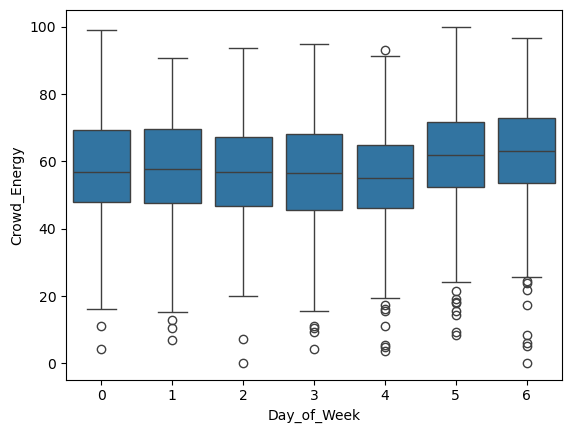

In [14]:
# plotting crowd_energy against days of the week to verify singer's claims about tuesday shows
# the median for tuesday is almost the same as rest of the days, so tuesday shows are NOT cursed, but also aren't the best

sns.boxplot(data = df_eda, x = "Day_of_Week", y = "Crowd_Energy")

<Axes: xlabel='Hour', ylabel='Crowd_Energy'>

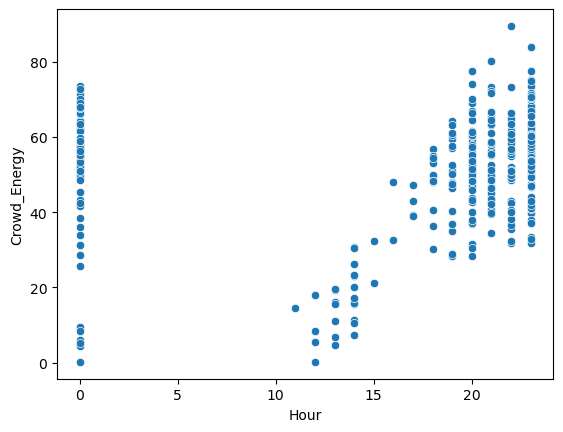

In [15]:
# this is to check if gothic night club (venue beta) has higher energy during night shows
# this is true since a large number of points are after 20 and near 0
sns.scatterplot(data = df_eda[df_eda["Venue_ID"] == "V_Beta"], x = "Hour", y = "Crowd_Energy")

<Axes: xlabel='Venue_ID', ylabel='Crowd_Energy'>

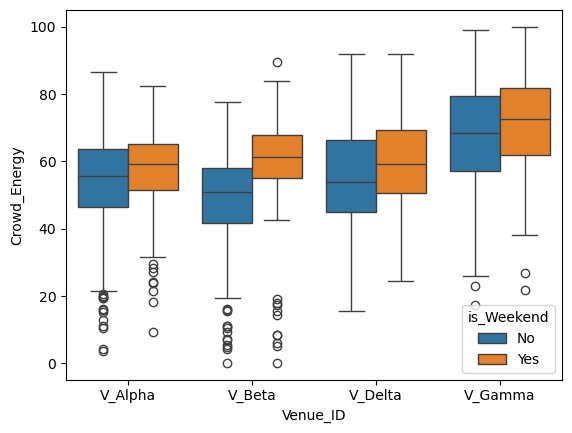

In [16]:
# checking to see if weekend shows are actually better, and for what venues
# we see that weekend shows are better in all venues, with venue beta having a significant differnce compared to others
sns.boxplot(data = df_eda, x = "Venue_ID", y = "Crowd_Energy", hue = "is_Weekend")

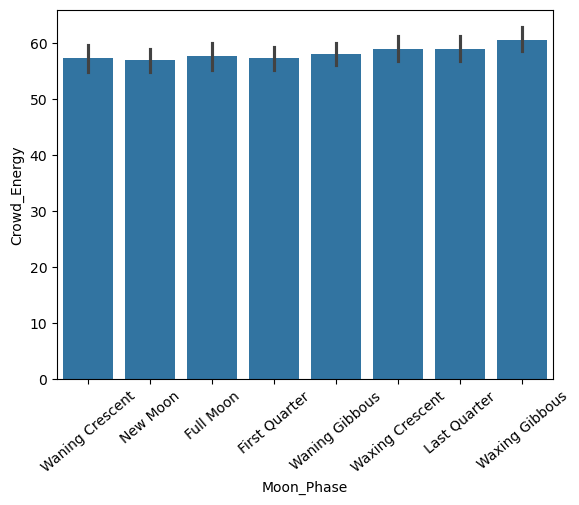

In [17]:
# checking to see if full moon shows are better or not
# there isnt any difference, all the shows have roughly the same crowd energy
ax = sns.barplot(data=df_eda, x="Moon_Phase", y="Crowd_Energy")
ax.tick_params(axis='x', labelrotation=40)

<Axes: xlabel='Weather', ylabel='Crowd_Energy'>

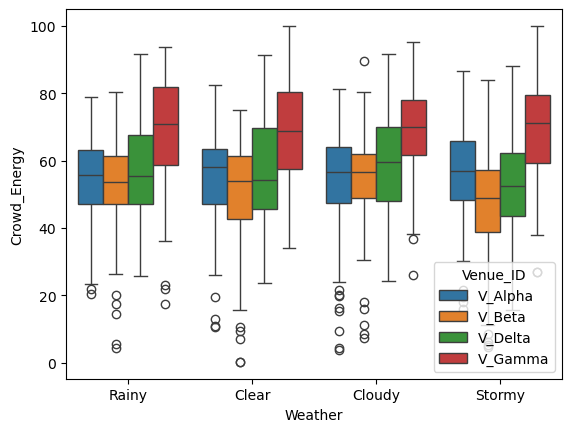

In [18]:
# rain doesnt create much difference in crowd energy compared to other weather conditions for the same venue
# venue gamma performs better than others in all weather conditions
# venue delta doesnt suffer alone in storms so it isnt necessarily outdoors, reason is something else
# venue delta doenst perform that well in the rain compared to venue gamma, so mosh pits aren't 'legendary' in the rain
sns.boxplot(data = df_eda, x = "Weather", y = "Crowd_Energy", hue = "Venue_ID")

<Axes: xlabel='Volume_Level', ylabel='Crowd_Energy'>

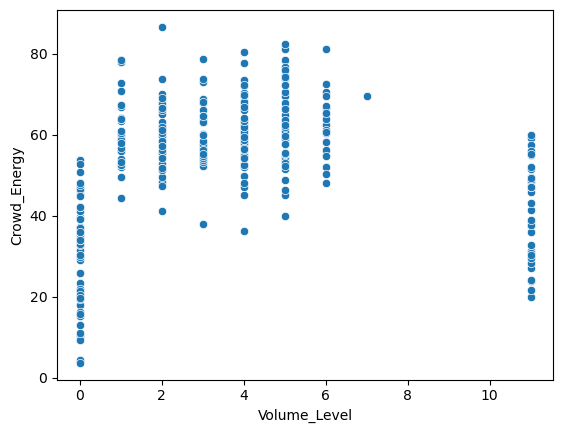

In [19]:
# in venue alpha (where the monks are), data points for crowd energy die down after volume level 6
# so there is a volume limit at the monastery where the monks dont tolerate high volume
# also since there is no data point for high volume levels, he doesnt tolerate high volumes, even if the crowd size is large
sns.scatterplot(data = df_eda[df_eda["Venue_ID"] == "V_Alpha"], x = "Volume_Level", y = "Crowd_Energy")

<Axes: xlabel='Volume_Level', ylabel='Crowd_Energy'>

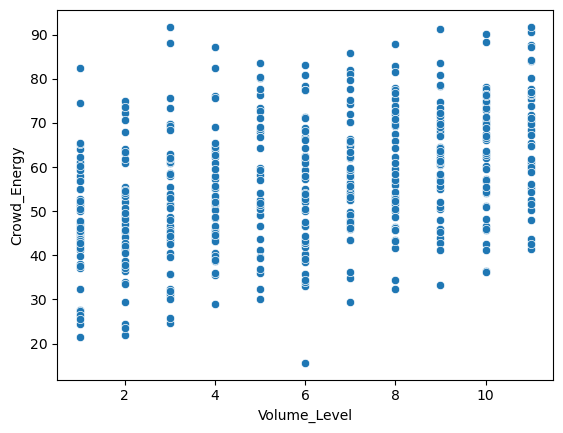

In [20]:
# crowd energy becomes higher for higher volumes, so 'louder is better' at the mosh pit
sns.scatterplot(data = df_eda[df_eda["Venue_ID"] == "V_Delta"], x = "Volume_Level", y = "Crowd_Energy")

<Axes: xlabel='Crowd_Size', ylabel='Crowd_Energy'>

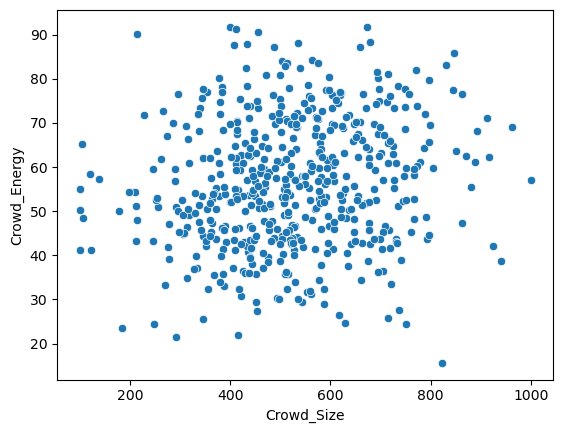

In [21]:
# venue delta has crowd sizes till 1000, with most of the points (in the >800 region) in the high crowd energy region, so it seems true that mosh pits feeds itself
sns.scatterplot(data = df_eda[df_eda["Venue_ID"] == "V_Delta"], x = "Crowd_Size", y = "Crowd_Energy")

<Axes: xlabel='Ticket_Price', ylabel='Crowd_Energy'>

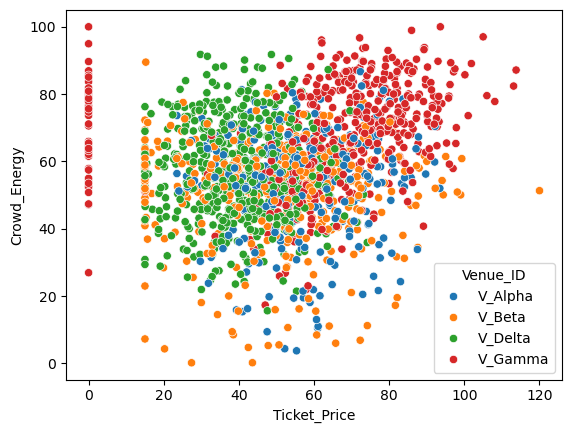

In [22]:
# in venue gamnma, expensive shows have higher energy with the range of prices 20-60 being almost empty
# venue delta (the mosh pit) is the opposite with higher energy in cheaper shows
# these venues seem price sensitive
sns.scatterplot(data = df_eda, x = "Ticket_Price", y = "Crowd_Energy", hue = "Venue_ID")

<Axes: xlabel='Price_Range', ylabel='Count'>

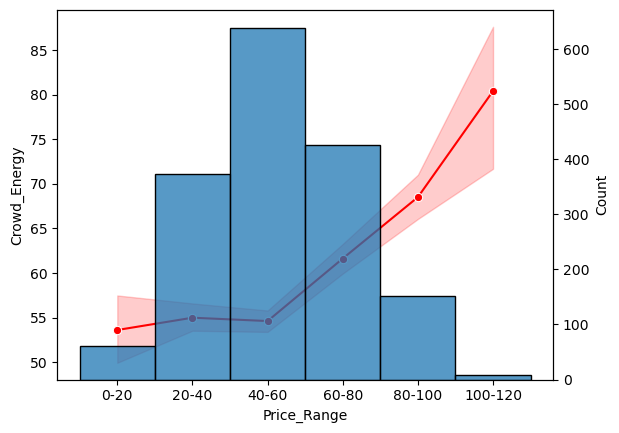

In [23]:
sns.lineplot(data = df_eda, x = "Price_Range", y = "Crowd_Energy", marker = "o", color = "red")
ax = plt.twinx()
sns.histplot(data = df_eda, x = "Price_Range", ax = ax)

# peak energy is at a higher price range, but since the number of data points is less, its not reliable
# the 'sweet spot' seems to be at 40-80, where the energy is high and the number of data points makes it reliable

<Axes: xlabel='Venue_ID', ylabel='Band_Outfit'>

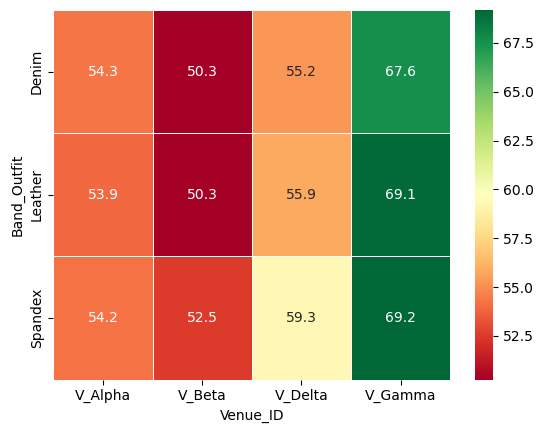

In [24]:
pivot_table = df_eda.pivot_table(index = "Band_Outfit", columns = "Venue_ID", values = "Crowd_Energy", aggfunc = "mean")
sns.heatmap(pivot_table, annot = True, fmt = "0.1f", cmap = "RdYlGn", linewidth = 0.5)

# for venue alpha, outfits dont seem to play much role, best one begin leather, although the differnce is not that large
# for venue beta, spandex perform best by almost 2 points
# for venue delta as well, spandex performs very well with a difference of around 4 points
# for venue gamma, all outfits perform well compared to other venues, with spandex and leather perfrming better than denim, the 
# differnence is small though

In [25]:
df_train.columns

Index(['Gig_ID', 'Venue_ID', 'Show_DateTime', 'Day_of_Week', 'Volume_Level',
       'Ticket_Price', 'Crowd_Size', 'Opener_Rating', 'Weather', 'Moon_Phase',
       'Band_Outfit', 'Merch_Sales_Post_Show', 'Crowd_Energy', 'Hour',
       'is_Weekend', 'Price_Range', 'Relative_Price', 'Venue_Outfit', 'Month',
       'Days_Elapsed', 'Price_Dist'],
      dtype='object')

In [26]:
x_train = df_train.drop(columns = ["Gig_ID", "Merch_Sales_Post_Show", "Crowd_Energy", "Show_DateTime"])
y_train = df_train["Crowd_Energy"]
x_test = df_test.drop(columns = ["Gig_ID", "Merch_Sales_Post_Show", "Show_DateTime"])
x_train

,Venue_ID,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Hour,is_Weekend,Price_Range,Relative_Price,Venue_Outfit,Month,Days_Elapsed,Price_Dist
0,V_Alpha,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,21,No,40-60,-2.560743,V_Alpha_Leather,3,6,12.93
1,V_Beta,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,22,No,60-80,15.350524,V_Beta_Leather,9,188,26.33
2,V_Delta,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,15,Yes,40-60,11.635248,V_Delta_Denim,3,8,11.37
4,V_Delta,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,17,No,40-60,7.605248,V_Delta_Spandex,4,56,7.34
5,V_Alpha,2,3.0,69.63,320.0,4,Cloudy,First Quarter,Denim,20,No,60-80,14.139257,V_Alpha_Denim,9,194,29.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,V_Beta,0,7.0,55.01,323.0,3,Clear,New Moon,Denim,23,No,40-60,4.030524,V_Beta_Denim,6,101,15.01
1994,V_Beta,6,4.0,62.86,432.0,4,Cloudy,Waxing Gibbous,Denim,20,Yes,60-80,11.880524,V_Beta_Denim,8,170,22.86
1996,V_Beta,3,7.0,26.94,588.0,5,Stormy,Full Moon,Spandex,23,No,20-40,-24.039476,V_Beta_Spandex,5,83,13.06
1997,V_Beta,4,2.0,57.54,649.0,1,Rainy,Waning Gibbous,Leather,23,No,40-60,6.560524,V_Beta_Leather,6,121,17.54


In [27]:
x_train.min()

Venue_ID                V_Alpha
Day_of_Week                   0
Volume_Level                0.0
Ticket_Price                0.0
Crowd_Size                100.0
Opener_Rating                 1
Weather                   Clear
Moon_Phase        First Quarter
Band_Outfit               Denim
Hour                          0
is_Weekend                   No
Price_Range                0-20
Relative_Price       -64.397584
Venue_Outfit      V_Alpha_Denim
Month                         3
Days_Elapsed                  0
Price_Dist                  0.0
dtype: object

In [28]:
numeric_x = ["Volume_Level", "Ticket_Price", "Crowd_Size", "Opener_Rating", "Hour", "Relative_Price", "Month", "Days_Elapsed", "Price_Dist"]
categorical_x = ["Venue_ID", "Day_of_Week", "Weather", "Moon_Phase", "Band_Outfit", "is_Weekend", "Price_Range", "Venue_Outfit"]

numeric_transform = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorial_transform = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
                                       ("encoder", OneHotEncoder(handle_unknown = "ignore", sparse_output = False))])
preprocessor = ColumnTransformer(transformers = [("num", numeric_transform, numeric_x), ("cat", categorial_transform, categorical_x)], 
                                 verbose_feature_names_out = False)

x_train_processed = preprocessor.fit_transform(x_train)

x_test_processed = preprocessor.transform(x_test)

In [29]:
final_pipeline = Pipeline(steps = [("selector", SelectKBest(score_func = f_regression, k = 40)), 
                                   ("model", RandomForestRegressor(random_state = 42))])

parameters = {"model__n_estimators" : [200, 500], "model__max_depth":[20, None], 
              "model__min_samples_leaf":[2, 4]}

grid = GridSearchCV(estimator = final_pipeline, param_grid = parameters, cv = 5, scoring = "neg_root_mean_squared_error", n_jobs = -1)

grid.fit(x_train_processed, y_train)

print("Best parameters:", grid.best_params_)
print("Best RMSE (CV):", -grid.best_score_)

Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
Best RMSE (CV): 12.209585738252482


In [30]:
best_model = grid.best_estimator_

y_prediction = best_model.predict(x_test_processed)



In [31]:
df_pred = pd.DataFrame({"Gig_ID":df_test.loc[:, "Gig_ID"], "Crowd_Energy":y_prediction})
df_pred

,Gig_ID,Crowd_Energy
0,Gig_0000,62.775751
1,Gig_0001,61.654337
2,Gig_0002,63.437225
3,Gig_0003,36.641435
4,Gig_0004,46.852009
...,...,...
495,Gig_0495,37.850714
496,Gig_0496,65.235613
497,Gig_0497,60.135854
498,Gig_0498,44.618668


In [32]:
df_pred.to_csv("predictions.csv", index = False)

In [33]:
# Bonus problem

df_req = df_train[df_train["Venue_ID"] == "V_Gamma"].copy()
df_req = df_req[df_req["Crowd_Size"] < 800]
df_req = df_req.dropna(subset=["Crowd_Size", "Price_Range"])

# we assume a linear relationship : attendnace = slope*price + intercept
atten_curve = LinearRegression()
x_atten = df_req[["Ticket_Price"]]
y_atten = df_req["Crowd_Size"]
atten_curve.fit(x_atten, y_atten)
atten_slope = atten_curve.coef_[0]
atten_intercept = atten_curve.intercept_

# similarly for merch sales, we use expenditure per head
df_req_copy = df_req.copy()
df_req_copy["Spent_per_Head"] = df_req_copy["Merch_Sales_Post_Show"]/df_req_copy["Crowd_Size"]

# merch sales per head = slope*energy + intercept
merch_curve = LinearRegression()
x_merch = df_req_copy[["Crowd_Energy"]]
y_merch = df_req_copy["Spent_per_Head"]
merch_curve.fit(x_merch, y_merch)
merch_slope = merch_curve.coef_[0]
merch_intercept = merch_curve.intercept_

# simulating different price points
prices = np.linspace(20, 400, 381)
results = []

df_req = df_req.drop(columns = ["Gig_ID", "Merch_Sales_Post_Show", "Crowd_Energy", "Show_DateTime"])

for price in prices:
    df_temp = df_req.copy()

    pred_atten = atten_slope*price + atten_intercept
    pred_atten = min(max(pred_atten, 0), 800)
    df_temp["Crowd_Size"] = pred_atten
    
    df_temp["Ticket_Price"] = price
    df_temp["Relative_Price"] = price - df_req["Ticket_Price"].mean()
    df_temp["Price_Dist"] = abs(price-40)
    
    bins = [0, 20, 40, 60, 80, 100, 120]
    labels = ["0-20", "20-40", "40-60", "60-80", "80-100", "100-120"]
    df_temp["Price_Range"] = pd.cut(df_temp["Ticket_Price"], bins = bins, labels = labels)
    
    df_temp = preprocessor.transform(df_temp)
    pred_energy = best_model.predict(df_temp)
    avg_energy = pred_energy.mean()

    cost = 5000+(8*pred_atten)

    ticket_revenue = price*pred_atten

    pred_merch = merch_slope*avg_energy + merch_intercept
    merch_revenue = pred_merch*pred_atten

    profit = merch_revenue + ticket_revenue - cost

    results.append({"Price":price, "Attendance":pred_atten, "Avg_Energy":avg_energy, "Profit":profit})

df_res = pd.DataFrame(results)
best = df_res.loc[df_res["Profit"].idxmax()]
optimal_price = best["Price"]
best

Price           291.000000
Attendance      292.659524
Avg_Energy       74.473213
Profit        78535.448548
Name: 271, dtype: float64

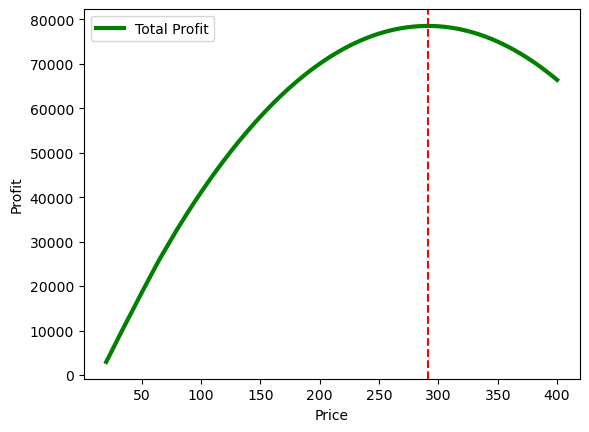

In [34]:
sns.lineplot(data=df_res, x='Price', y='Profit', color='green', linewidth=3, label='Total Profit')
plt.axvline(optimal_price, color='red', linestyle='--', label=f'Optimal Price: ${optimal_price:.2f}')